### Prof. Pedram Jahangiry

## Resources Consulted
- [Nixtla MLForecast documentation](https://nixtlaverse.nixtla.io/mlforecast/index.html)
- [One model per horizon guide](https://nixtlaverse.nixtla.io/mlforecast/docs/how-to-guides/one_model_per_horizon.html)
- Original Module 5 notebook (`Module5-ML_timesereis.ipynb`) for baseline comparisons


## Notebook Roadmap
1. Load the airline passengers data and reshape it into Nixtla's long format.
2. Benchmark MLForecast's default recursive pipeline for one-step vs multi-step evaluation.
3. Try MLForecast's direct strategy (`max_horizon`) to emulate multi-output forecasting.
4. Compare error metrics and visualize the 12-month horizon forecasts.


## Imports and Configuration
We'll lean on `mlforecast` for feature engineering plus scikit-learn regressors for the underlying models.


In [32]:
# If mlforecast is missing in a fresh environment, uncomment the next line.
# !pip install mlforecast

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import sqrt
from IPython.display import display
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 4)
pd.set_option('display.float_format', lambda x: f"{x:0.2f}")

HORIZON = 12


## Dataset Overview
We keep the airline passenger data used throughout the module and convert it to Nixtla's `unique_id`/`ds`/`y` layout.


In [33]:
data_url = 'https://raw.githubusercontent.com/PJalgotrader/Deep_forecasting-USU/main/data/airline_passengers.csv'
raw_df = pd.read_csv(data_url)
raw_df['Month'] = pd.to_datetime(raw_df['Month'])
raw_df['unique_id'] = 'air_passengers'
raw_df = raw_df.rename(columns={'Month': 'ds', 'Passengers': 'y'})
raw_df = raw_df[['unique_id', 'ds', 'y']].sort_values('ds').reset_index(drop=True)

print(f"Observations: {len(raw_df)} | Range: {raw_df['ds'].min().date()} - {raw_df['ds'].max().date()}")
raw_df.head()


Observations: 144 | Range: 1949-01-01 - 1960-12-01


,unique_id,ds,y
0,air_passengers,1949-01-01,112
1,air_passengers,1949-02-01,118
2,air_passengers,1949-03-01,132
3,air_passengers,1949-04-01,129
4,air_passengers,1949-05-01,121


## Visualize the monthly demand
The seasonal trend motivates the 12-month lag features we'll feed to MLForecast.


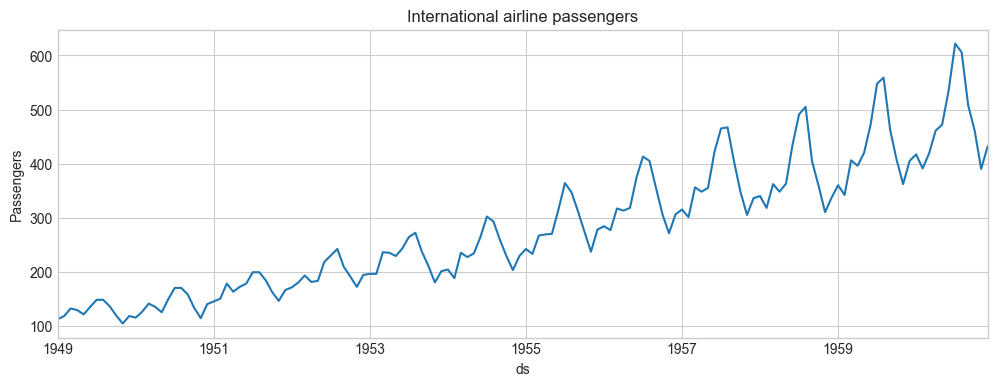

In [34]:
raw_df.set_index('ds')['y'].plot(title='International airline passengers')
plt.ylabel('Passengers')
plt.show()


## Train/Test Reference Window
We'll treat the final 12 months as the evaluation horizon and keep the last few years for plotting context.


In [35]:
train_df = raw_df.iloc[:-HORIZON].copy()
test_df = raw_df.iloc[-HORIZON:].copy()
history_df = raw_df.iloc[-(HORIZON * 3):].copy()

print(f"Train observations: {len(train_df)} | Test observations: {len(test_df)}")
test_df.head()


Train observations: 132 | Test observations: 12


,unique_id,ds,y
132,air_passengers,1960-01-01,417
133,air_passengers,1960-02-01,391
134,air_passengers,1960-03-01,419
135,air_passengers,1960-04-01,461
136,air_passengers,1960-05-01,472


## Helper Utilities
Utility functions for adding the forecast step index, computing error summaries, and plotting forecasts against the held-out window.


In [36]:
def add_step_column(cv_df: pd.DataFrame) -> pd.DataFrame:
    out = cv_df.copy()
    out['step'] = out.groupby(['unique_id', 'cutoff']).cumcount() + 1
    return out


def prediction_columns(cv_df: pd.DataFrame):
    return [c for c in cv_df.columns if c not in ['unique_id', 'ds', 'cutoff', 'y', 'step']]


def preview_cv(cv_df: pd.DataFrame, rows: int = 5) -> pd.DataFrame:
    cv = add_step_column(cv_df)
    cols = ['unique_id', 'cutoff', 'ds', 'step', 'y'] + prediction_columns(cv)
    return cv[cols].head(rows)


def evaluate_cv(cv_df: pd.DataFrame, label: str) -> pd.DataFrame:
    cv = add_step_column(cv_df)
    preds = prediction_columns(cv)
    results = []
    for model in preds:
        for scenario, mask in [('OSA (h=1)', cv['step'] == 1), ('MSA (h<=H)', cv['step'] >= 1)]:
            errors = cv.loc[mask, 'y'] - cv.loc[mask, model]
            denom = cv.loc[mask, 'y'].replace(0, np.nan).abs()
            ape = errors.abs().divide(denom).replace([np.inf, -np.inf], np.nan).dropna()
            mape = float(ape.mean() * 100) if not ape.empty else np.nan
            results.append({
                'Setup': label,
                'Model': model,
                'Scenario': scenario,
                'MAE': errors.abs().mean(),
                'RMSE': np.sqrt(np.mean(errors ** 2)),
                'MAPE': mape,
            })
    return pd.DataFrame(results)


def plot_forecasts(forecast_df: pd.DataFrame, actual_history: pd.DataFrame, title: str) -> None:
    predictions = forecast_df.set_index('ds').drop(columns=['unique_id'])
    ax = actual_history.set_index('ds')['y'].plot(color='black', lw=2, label='Actual')
    predictions.plot(ax=ax, lw=2)
    ax.set_title(title)
    ax.set_ylabel('Passengers')
    ax.legend(loc='upper left')
    plt.show()


## Recursive Strategy (default MLForecast)
Instantiate MLForecast with linear and random forest regressors, relying on 1- and 12-month lags plus a single seasonal difference. The default prediction loop is recursive, so horizons beyond one step reuse prior forecasts.


In [37]:
recursive_models = [
    LinearRegression(),
    RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
]

recursive_fcst = MLForecast(
    models=recursive_models,
    freq='MS',
    lags=[1, 12],
    target_transforms=[Differences([1])],
)

recursive_fcst.fit(df=raw_df)
recursive_cv = recursive_fcst.cross_validation(df=raw_df, n_windows=1, h=HORIZON)
preview_cv(recursive_cv)


,unique_id,cutoff,ds,step,y,LinearRegression,RandomForestRegressor
0,air_passengers,1959-12-01,1960-01-01,1,417,430.28,418.65
1,air_passengers,1959-12-01,1960-02-01,2,391,411.42,405.20
2,air_passengers,1959-12-01,1960-03-01,3,419,480.55,470.71
3,air_passengers,1959-12-01,1960-04-01,4,461,470.45,460.33
4,air_passengers,1959-12-01,1960-05-01,5,472,496.61,481.83


In [38]:
recursive_summary = evaluate_cv(recursive_cv, label='Recursive (default)')
recursive_summary.round(2)


,Setup,Model,Scenario,MAE,RMSE,MAPE
0,Recursive (default),LinearRegression,OSA (h=1),13.28,13.28,3.18
1,Recursive (default),LinearRegression,MSA (h<=H),30.10,34.24,6.59
2,Recursive (default),RandomForestRegressor,OSA (h=1),1.65,1.65,0.40
3,Recursive (default),RandomForestRegressor,MSA (h<=H),15.17,20.98,3.29


### Recursive 12-month forecast
Refit on the full history so the stored models are available for `.predict`, then generate the 12-step horizon.


In [39]:
recursive_fcst.fit(df=raw_df)
recursive_forecast = recursive_fcst.predict(HORIZON)
recursive_forecast


,unique_id,ds,LinearRegression,RandomForestRegressor
0,air_passengers,1961-01-01,444.92,436.19
1,air_passengers,1961-02-01,417.88,404.14
2,air_passengers,1961-03-01,447.04,436.70
3,air_passengers,1961-04-01,491.24,487.48
4,air_passengers,1961-05-01,503.13,485.59
5,air_passengers,1961-06-01,569.18,544.10
6,air_passengers,1961-07-01,660.71,620.35
7,air_passengers,1961-08-01,644.70,610.78
8,air_passengers,1961-09-01,542.15,518.48
9,air_passengers,1961-10-01,492.32,465.92


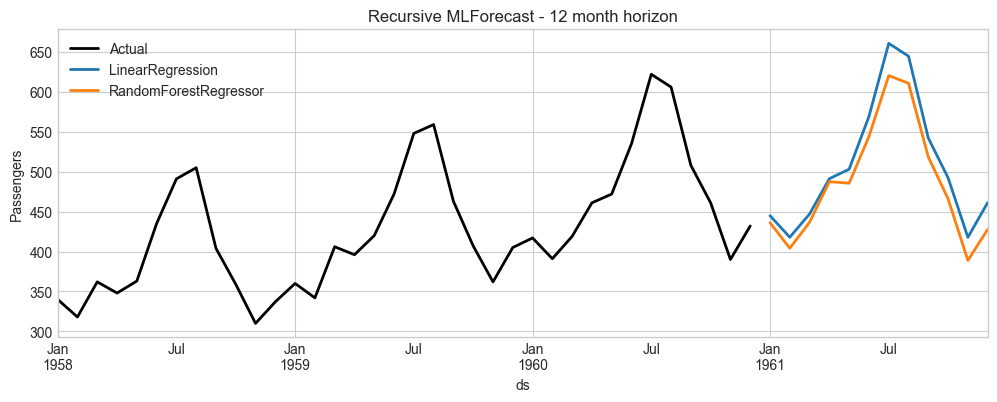

In [40]:
plot_forecasts(recursive_forecast, history_df, 'Recursive MLForecast - 12 month horizon')


## Direct / Multioutput Strategy via `max_horizon`
Setting `max_horizon=12` trains one model per forecast step (Nixtla's direct strategy), mirroring the multi-output block from the original scikit-learn notebook.


In [41]:
direct_fcst = MLForecast(
    models=recursive_models,
    freq='MS',
    lags=[1, 12],
    target_transforms=[Differences([1])],
)

direct_fcst.fit(df=raw_df, max_horizon=HORIZON)
direct_cv = direct_fcst.cross_validation(
    df=raw_df,
    n_windows=1,
    h=HORIZON,
    max_horizon=HORIZON,
)
preview_cv(direct_cv)


,unique_id,cutoff,ds,step,y,LinearRegression,RandomForestRegressor
0,air_passengers,1959-12-01,1960-01-01,1,417,430.28,418.65
1,air_passengers,1959-12-01,1960-02-01,2,391,432.35,400.52
2,air_passengers,1959-12-01,1960-03-01,3,419,423.09,383.60
3,air_passengers,1959-12-01,1960-04-01,4,461,409.42,370.64
4,air_passengers,1959-12-01,1960-05-01,5,472,405.34,356.76


In [42]:
direct_summary = evaluate_cv(direct_cv, label='Direct (max_horizon)')
direct_summary.round(2)


,Setup,Model,Scenario,MAE,RMSE,MAPE
0,Direct (max_horizon),LinearRegression,OSA (h=1),13.28,13.28,3.18
1,Direct (max_horizon),LinearRegression,MSA (h<=H),81.52,111.10,15.32
2,Direct (max_horizon),RandomForestRegressor,OSA (h=1),1.65,1.65,0.40
3,Direct (max_horizon),RandomForestRegressor,MSA (h<=H),83.46,109.24,15.85


In [43]:
direct_fcst.fit(df=raw_df, max_horizon=HORIZON)
direct_forecast = direct_fcst.predict(HORIZON)
direct_forecast


,unique_id,ds,LinearRegression,RandomForestRegressor
0,air_passengers,1961-01-01,444.92,436.19
1,air_passengers,1961-02-01,442.00,430.63
2,air_passengers,1961-03-01,434.36,464.02
3,air_passengers,1961-04-01,423.94,460.17
4,air_passengers,1961-05-01,422.88,460.88
5,air_passengers,1961-06-01,421.41,486.23
6,air_passengers,1961-07-01,419.09,487.57
7,air_passengers,1961-08-01,406.95,502.74
8,air_passengers,1961-09-01,399.88,456.96
9,air_passengers,1961-10-01,397.38,423.86


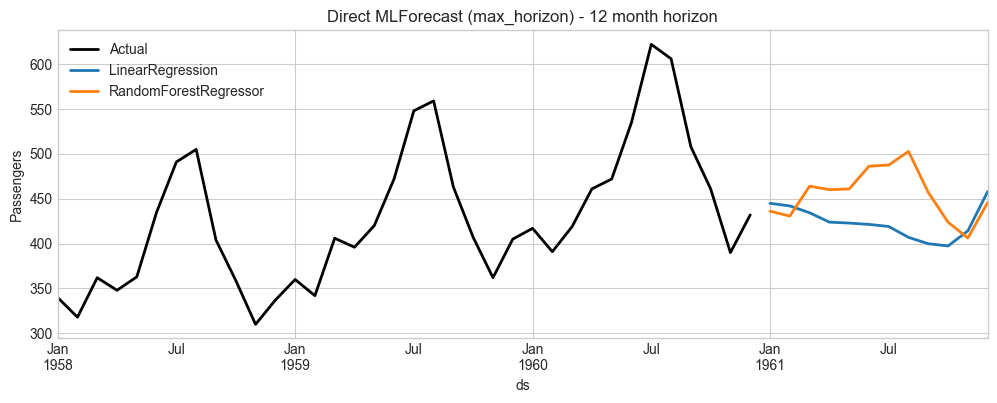

In [44]:
plot_forecasts(direct_forecast, history_df, 'Direct MLForecast (max_horizon) - 12 month horizon')


## Comparing Strategies
Combine the summary tables to see how recursive vs direct training differ for one-step and multi-step error profiles.


In [45]:
comparison = pd.concat([recursive_summary, direct_summary], ignore_index=True)
comparison_pivot = (comparison
                    .pivot_table(index=['Setup', 'Model'], columns='Scenario', values=['MAE', 'RMSE', 'MAPE'])
                    .sort_index())
comparison_pivot.round(2)


MAE                 MAPE  \
Scenario                                   MSA (h<=H) OSA (h=1) MSA (h<=H)   
Setup                Model                                                   
Direct (max_horizon) LinearRegression           81.52     13.28      15.32   
                     RandomForestRegressor      83.46      1.65      15.85   
Recursive (default)  LinearRegression           30.10     13.28       6.59   
                     RandomForestRegressor      15.17      1.65       3.29   

                                                           RMSE            
Scenario                                   OSA (h=1) MSA (h<=H) OSA (h=1)  
Setup                Model                                                 
Direct (max_horizon) LinearRegression           3.18     111.10     13.28  
                     RandomForestRegressor      0.40     109.24      1.65  
Recursive (default)  LinearRegression           3.18      34.24     13.28  
                     RandomForestRegressor      0.40      20.98      1.65

## Summary
- MLForecast's default recursive loop reproduces the scikit-learn workflow: tight one-step errors and larger multi-step deviations when the model reuses its own predictions.
- Enabling `max_horizon` mirrors the multi-output idea from Module 5, training separate models per horizon. It can reduce the compounding bias of recursion but may overfit when data is scarce.
- Both approaches operate on the same Nixtla-friendly data format, so you can swap in other regressors or extend the cross-validation windows without rewriting the feature engineering code.
- PyCaret can slot in on top of these outputs: the `recursive_summary` rows correspond to its default `fh=1` evaluation, while the direct strategy illustrates how to approximate its out-of-sample multi-step forecasts inside the Nixtla ecosystem.
